## Parte 2

En esta sección incorporamos algunos predictores que trabajarán sobre la base de datos limpia obtenida previamente. Matemáticamente, debemos encontrar una función h(x,w), donde x son las variables y w son los pesos asociados al predictor, tal que minimice una funcion de pérdida L (loss) sobre el conjunto de entrenamiento, dadas las etiquetas reales y, es decir:

%%latex


\begin{equation*}
\begin{aligned}
& \underset{w \in \mathbb{R}^{d}}{\text{minimize}}
& & \frac{1}{n}\sum_{i}^{n}L(h(x_{i},w),y_{i}) \\
\end{aligned}
\end{equation*}

Variacionalmente esto se refiere a minimizar el riesgo empírico sobre el conjunto de las funciones h. En esta sección probaremos clasificadores del tipo árbol, baggedtrees y redes neuronales:

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline 

In [2]:
#Importar la base de datos
local_path = r'/Users/pablouribepizarro/Desktop/Analisis de Datos/Tarea_1/'
datos = pd.read_csv(local_path + 'data_new_features_clean.csv',index_col =0)


In [3]:
#Cambiar el formato de las fechas a datetime

datos['FechaNac'] = pd.to_datetime(datos['FechaNac'])
datos['FechaReserva'] = pd.to_datetime(datos['FechaReserva'])
datos['FechaCita'] = pd.to_datetime(datos['FechaCita'])
datos = datos.sort_values('FechaCita')

In [4]:
#Encode Data into Numerical
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


column_list = [] #str columns
for column in datos.columns:
    if datos[column].dtype == 'O':
        column_list.append(column)

datos_num = datos[column_list].astype(str).apply(le.fit_transform)
for column in datos.columns:
    if datos[column].dtype != 'O':
        datos_num[column] = datos[column]

## Creación de una muestra balanceada:

Recordando que en la parte 1 el análisis de frecuencia del fenómeno en la base de datos dió como resultado una base de datos desbalanceada, en esta parte abordaremos una de las posibles soluciones asociadas a este problema: la creación de una muestra balanceada.

In [5]:
#Creación de una muestra balanceada:
datos_cancelaciones = datos.loc[datos['EstadoCita'] == 'Cancelado'].copy()
datos_atenciones = datos.loc[datos['EstadoCita'] == 'Atendido'].copy()
datos_noatenciones = datos.loc[datos['EstadoCita'] == 'No Atendido'].copy()

num = min(datos_cancelaciones.shape[0],datos_atenciones.shape[0],datos_noatenciones.shape[0])
cancelaciones_sample = datos_cancelaciones.sample(num)
atenciones_sample = datos_atenciones.sample(num)
noatenciones_sample = datos_noatenciones.sample(num)

balanced_sample = pd.concat([cancelaciones_sample,atenciones_sample,noatenciones_sample]).sample(frac=1)

In [6]:
#Encoder String a Numérico
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


column_list = [] #str columns
for column in datos.columns:
    if balanced_sample[column].dtype == 'O':
        column_list.append(column)

datos_num = balanced_sample[column_list].astype(str).apply(le.fit_transform)
for column in balanced_sample.columns:
    if balanced_sample[column].dtype != 'O':
        datos_num[column] = balanced_sample[column]


Varios de los algoritmos de clasificación no son de "escala invariante" (por ej. los SVM). Por este motivo, se aplica una estandatización previa de los datos, y se divide la base en una muestra de entrenamiento y otra de validación:

In [7]:
#Estandarización de los Datos
from sklearn import preprocessing
stand_data = preprocessing.StandardScaler().fit_transform(datos_num.drop(
                                                ['FechaNac','FechaCita','FechaReserva','EstadoCita'],axis=1))
stand_data = pd.DataFrame(stand_data)
stand_data.columns = datos_num.drop(
                                        ['FechaNac','FechaCita','FechaReserva','EstadoCita'],axis=1).columns.values
stand_data= stand_data.set_index(datos_num.index.values)
stand_data['EstadoCita'] = datos_num['EstadoCita']

In [8]:
#Creación de una muestra de entrenamiento y validación:
msk = np.random.rand(len(stand_data)) < 0.5
train = stand_data[msk]
test = stand_data[~msk]

In [9]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Training Time: 0.058670759201049805
Score: 0.4225457820474332
Feature Importances: [0.09385859 0.3348435  0.10647497 0.0630002  0.18592606 0.10341081
 0.0243521  0.07847821 0.00965555]


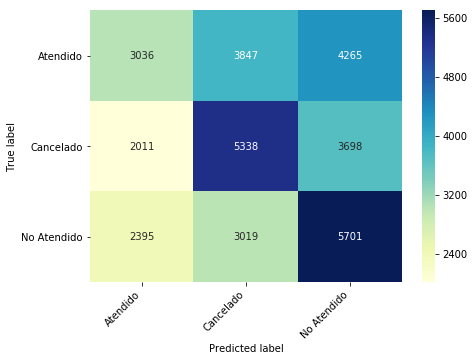

In [22]:
#Decision Tree Classifiers
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

#Orginal Variables

clf1 = DecisionTreeClassifier(random_state=0,criterion='entropy')
start = time.time()
clf1.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']], train['EstadoCita'])
end = time.time()
print('Training Time: '+str(end-start))
score = clf1.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']], test['EstadoCita'])
print('Score: '+str(score))
print('Feature Importances: '+str(clf1.feature_importances_))

#Confussion Matrix

y_pred = clf1.predict(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']])
class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'],y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

Training Time: 0.42726707458496094
Score: 0.4214950465325728
Feature Importance: [0.02902817 0.10020202 0.01819307 0.01033401 0.03428373 0.01231298
 0.00390728 0.02322357 0.00521642 0.25033335 0.18035579 0.05045476
 0.03534381 0.04179239 0.02458426 0.00838039 0.06139455 0.11065945]


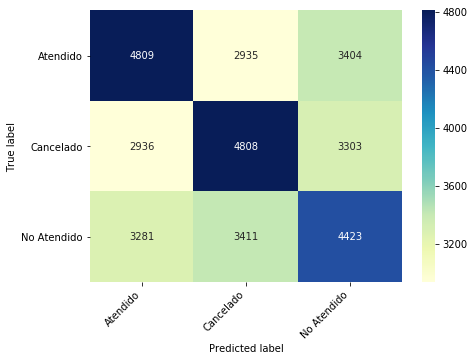

In [33]:
#New Variables

clf2 = DecisionTreeClassifier(random_state=0,criterion='entropy')
start = time.time()
clf2.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda',
                   'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita','Mes Cita']], train['EstadoCita'])
end = time.time()
print('Training Time: '+str(end-start))
score = clf2.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita','Mes Cita']], test['EstadoCita'])
print('Score: '+str(score))
print('Feature Importance: '+str(clf2.feature_importances_))

#Confussion Matrix
y_pred=clf2.predict(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita','Mes Cita']])
class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'], y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

Training Time: 0.9123549461364746
Score: 0.4275292704893425


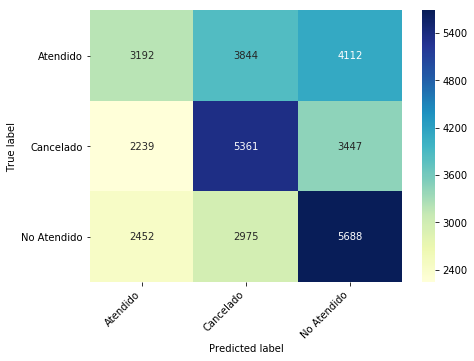

In [24]:
#BaggedTrees: Original Features
from sklearn.ensemble import BaggingClassifier
btc1 = BaggingClassifier(base_estimator= DecisionTreeClassifier(random_state=0,criterion='entropy'),
                         n_estimators=50,max_samples=0.9,max_features=0.8,bootstrap_features=True)
start = time.time()
btc1.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']], train['EstadoCita'])
end = time.time()
print('Training Time: '+str(end-start))
score = btc1.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']], test['EstadoCita'])
print('Score: '+str(score))


#Confussion Matrix

y_pred = btc1.predict(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']])
class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'],y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

Training Time: 5.383749961853027
Score: 0.48120684479135395


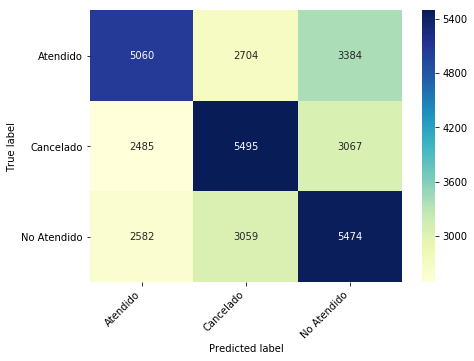

In [35]:
#BaggedTrees: New Features
from sklearn.ensemble import BaggingClassifier
btc2 = BaggingClassifier(base_estimator= DecisionTreeClassifier(random_state=0,criterion='entropy'),
                         n_estimators=50,max_samples=0.5,max_features=0.8,bootstrap_features=True)
start = time.time()
btc2.fit(train[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda',
                   'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita','Mes Cita']], train['EstadoCita'])
end = time.time()
print('Training Time: '+str(end-start))
score = btc2.score(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita','Mes Cita']], test['EstadoCita'])
print('Score: '+str(score))
#Confussion Matrix
y_pred=btc2.predict(test[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita','Mes Cita']])
class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'], y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

In [28]:
#Neuronal Network
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,ReLU
from keras.optimizers import SGD

# Generate dummy data
x_train = train[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']]
y_train = keras.utils.to_categorical(train['EstadoCita'])
x_test = test[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']]
y_test = keras.utils.to_categorical(test['EstadoCita'])

model = Sequential()
model.add(Dense(20, activation='relu', input_dim=11))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_hinge',
              optimizer=sgd,
              metrics=['accuracy'])
start = time.time()
model.fit(x_train, y_train,
          epochs=10,
          batch_size=128)

end = time.time()
print('Training Time: '+str(end-start))

score = model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/10
33032/33032 [==============================] - 2s 60us/step - loss: 1.0333 - acc: 0.3454
Epoch 2/10
33032/33032 [==============================] - 1s 30us/step - loss: 1.0059 - acc: 0.3467
Epoch 3/10
33032/33032 [==============================] - 1s 31us/step - loss: 1.0017 - acc: 0.3479
Epoch 4/10
33032/33032 [==============================] - 1s 33us/step - loss: 1.0007 - acc: 0.3418
Epoch 5/10
33032/33032 [==============================] - 1s 34us/step - loss: 1.0004 - acc: 0.3409
Epoch 6/10
33032/33032 [==============================] - 1s 31us/step - loss: 1.0003 - acc: 0.3405
Epoch 7/10
33032/33032 [==============================] - 1s 31us/step - loss: 1.0003 - acc: 0.3407
Epoch 8/10
33032/33032 [==============================] - 1s 31us/step - loss: 1.0002 - acc: 0.3378
Epoch 9/10
33032/33032 [==============================] - 1s 34us/step - loss: 1.0002 - acc: 0.3407
Epoch 10/10
33032/33032 [==============================] - 1s 33us/step - loss: 0.9999 - acc: 0.3440

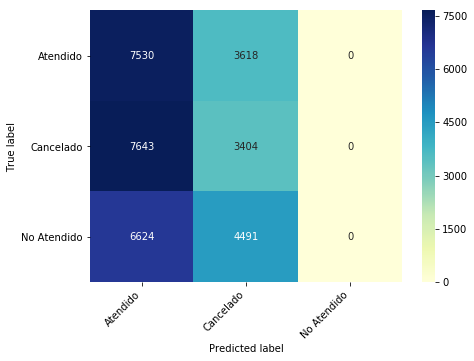

In [29]:
y_pred=np.argmax(model.predict(test[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita']]),axis=1)

class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'], y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

In [37]:
#Neuronal Network: Logistic Regression Architecture
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,ReLU
from keras.optimizers import SGD

# Generate dummy data
x_train = train[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita','Mes Cita']]
y_train = keras.utils.to_categorical(train['EstadoCita'])
x_test = test[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita','Mes Cita']]
y_test = keras.utils.to_categorical(test['EstadoCita'])

model = Sequential()
model.add(Dense(3, activation='sigmoid',input_dim=12))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_hinge',
              optimizer=sgd,
              metrics=['accuracy'])

start = time.time()
model.fit(x_train, y_train,
          epochs=10,
          batch_size=128)

end = time.time()
print('Training Time: '+str(end-start))

score = model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/10
33032/33032 [==============================] - 1s 43us/step - loss: 1.0511 - acc: 0.3632
Epoch 2/10
33032/33032 [==============================] - 0s 15us/step - loss: 1.0047 - acc: 0.4029
Epoch 3/10
33032/33032 [==============================] - 0s 15us/step - loss: 1.0009 - acc: 0.4014
Epoch 4/10
33032/33032 [==============================] - 0s 15us/step - loss: 1.0004 - acc: 0.3992
Epoch 5/10
33032/33032 [==============================] - 1s 18us/step - loss: 1.0002 - acc: 0.3979
Epoch 6/10
33032/33032 [==============================] - 1s 16us/step - loss: 1.0002 - acc: 0.3991
Epoch 7/10
33032/33032 [==============================] - 1s 17us/step - loss: 1.0002 - acc: 0.4024
Epoch 8/10
33032/33032 [==============================] - 1s 15us/step - loss: 1.0002 - acc: 0.4018
Epoch 9/10
33032/33032 [==============================] - 0s 15us/step - loss: 1.0002 - acc: 0.4016
Epoch 10/10
33032/33032 [==============================] - 1s 15us/step - loss: 1.0002 - acc: 0.3988

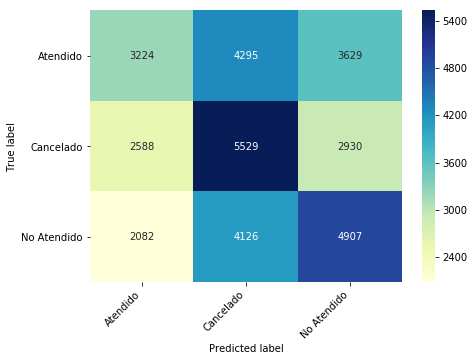

In [38]:
y_pred=np.argmax(model.predict(test[['Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita','Mes Cita']]),axis=1)

class_numbers = test['EstadoCita'].unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(test['EstadoCita'], y_pred)
cm_fig = print_confusion_matrix(cm,class_names)